### Regularización

Si el modelo es demasiado complejo ocurre el **sobreajuste** el modelo aprende sobre el ruido de nuestro modelo de entrenamiento y no es capaz de  generalizar bien.
Para evitar el sobreajuste(overfitting) se puede recurrir a simplificar el modelo o a poner limitaciones sobre el mismo. Esto se conoce con el nombre de regularización.
* Regularización Lasso o $L$: permite seleccionar los parámetros que más afectan al resultado. Se añade la función de coste:
\\[
Coste = {1 \over n} \sum_{i=0}^n{(Y-\hat{Y})^2}+\lambda \sum_j | \beta |
\\]
* Regularización Ridge o $L^2$: se evita que los parámetros crezcan demasiado. Se añade la función de coste:
\\[
Coste = {1 \over n} \sum_{i=0}^n{(Y-\hat{Y})^2}+\lambda \sum_j \beta^2
\\]
* Elástica: Una solución de compromiso entre las dos:
\\[
Coste = {1 \over n} \sum_{i=0}^n{(Y-\hat{Y})^2}+ \alpha \lambda \sum_j | \beta |+(1-\alpha)/2 \lambda \sum_j \beta^2
\\]


### Ejemplo regularización



Vamos a ver un ejemplo de regresión lineal con tres variables: x0, x1 y x2.

La función que tratamos de modelizar es del tipo:
\\[
y=\beta_1+\beta_2·x_1+\beta_3·x_2+\beta_4·x_3
\\]


In [1]:
#Definimos la función que queremos modelizar en función de beta
myfunction<-function(x_,beta){beta[1]+x_[,1]*beta[2]+x_[,2]*beta[3]+x_[,3]*beta[4]}

In [2]:
beta_real<-c(3,0.1,-5,4)

set.seed(123)
get_example_data_frame<-function(n=100){    
    x1<-runif(n,min=-10,max=10)
    x2<-rnorm(n,mean=7,sd=9)
    x3<-x1*rnorm(n,mean=3,sd=2)
 
    df<-data.frame(x1,x2,x3)
    df$y=myfunction(df,beta=beta_real)+rnorm(n,mean=0,sd=10)
    df
}
df<-get_example_data_frame()
head(df)

,x1,x2,x3,y
,<dbl>,<dbl>,<dbl>,<dbl>
1,-4.248450,9.279867,-19.438686,-125.33495
2,5.766103,6.743079,26.167061,68.91070
3,-1.820462,6.614166,-6.670909,-60.37568
4,7.660348,19.317421,7.532013,-61.78805
5,8.809346,4.968061,24.323438,92.31947
6,-9.088870,20.648235,-22.169657,-190.71434


In [3]:
cor(df)

,x1,x2,x3,y
x1,1.00000000,-0.02653768,0.85240646,0.7701336
x2,-0.02653768,1.00000000,0.01350409,-0.4503744
x3,0.85240646,0.01350409,1.00000000,0.8804553
y,0.77013363,-0.45037439,0.88045529,1.0000000


Loading required package: ggplot2

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



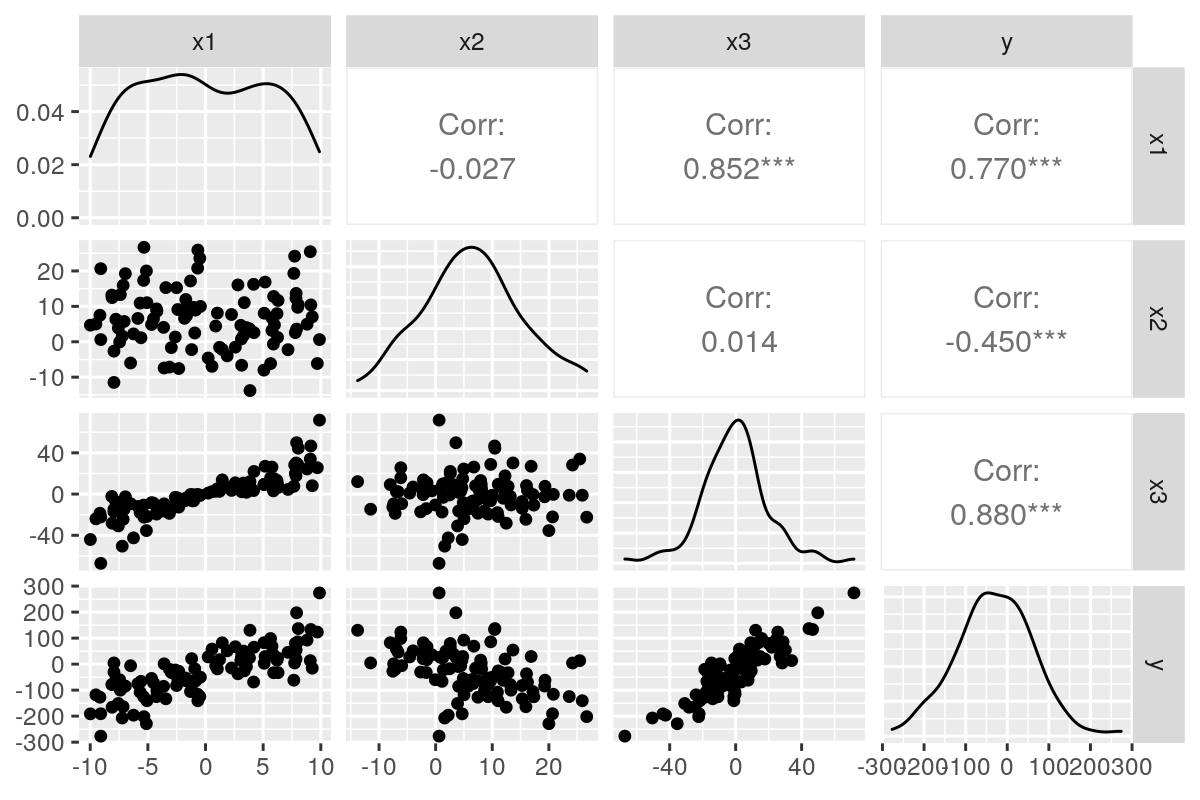

In [4]:
library(GGally)
options(repr.plot.height=4,repr.plot.width=6,repr.plot.res = 200)
ggpairs(df)

In [8]:
model <- lm(y~x1+x2+x3,data=df)
summary(model)


Call:
lm(formula = y ~ x1 + x2 + x3, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-21.560  -6.182  -0.610   7.208  21.655 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.37292    1.26409   3.459 0.000809 ***
x1           0.12385    0.34041   0.364 0.716792    
x2          -5.01778    0.11686 -42.938  < 2e-16 ***
x3           3.99738    0.09342  42.789  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 10.07 on 96 degrees of freedom
Multiple R-squared:  0.9889,	Adjusted R-squared:  0.9886 
F-statistic:  2862 on 3 and 96 DF,  p-value: < 2.2e-16


In [9]:
confint(model)

,2.5 %,97.5 %
(Intercept),1.8637169,6.8821136
x1,-0.5518635,0.7995614
x2,-5.2497484,-4.7858148
x3,3.8119412,4.1828175


In [10]:
library(pracma)
#Definimos una función de optimización que nos permite ver como evoluciona Beta

optim_beta<-function(mymodel,mse,maxiter=1e3,delta=0.0002,beta_0=c(0,0,0,0)){
    
    x_historico<-data.frame(beta1=rep(NA,maxiter),
                            beta2=rep(NA,maxiter),
                            beta3=rep(NA,maxiter),
                            beta4=rep(NA,maxiter),
                            mse=rep(NA,maxiter))
    x_historico[1,]<-c(beta_0,mse(beta_0))

    for (i in 2:maxiter){
        g <- grad(mse,beta_0)        
        beta_new <- beta_0 - g*delta
        beta_0 <- beta_new
        x_historico[i,]<-c(beta_0,mse=mse(beta_0))
    }
    x_historico<-na.omit(x_historico)
    nrow(x_historico)
    x_historico$step=1:nrow(x_historico)
    x_historico
}

In [11]:
#Definimos la métrica que queremos minimizar, en este caso el error cuadrático medio
mse<-function(beta){
    sum((df$y-myfunction(df[,c('x1','x2','x3')],beta))^2)/nrow(df)    
}
x_historico<-optim_beta(myfunction,mse,maxiter=1e4,delta=0.0005)

Loading required package: gridExtra



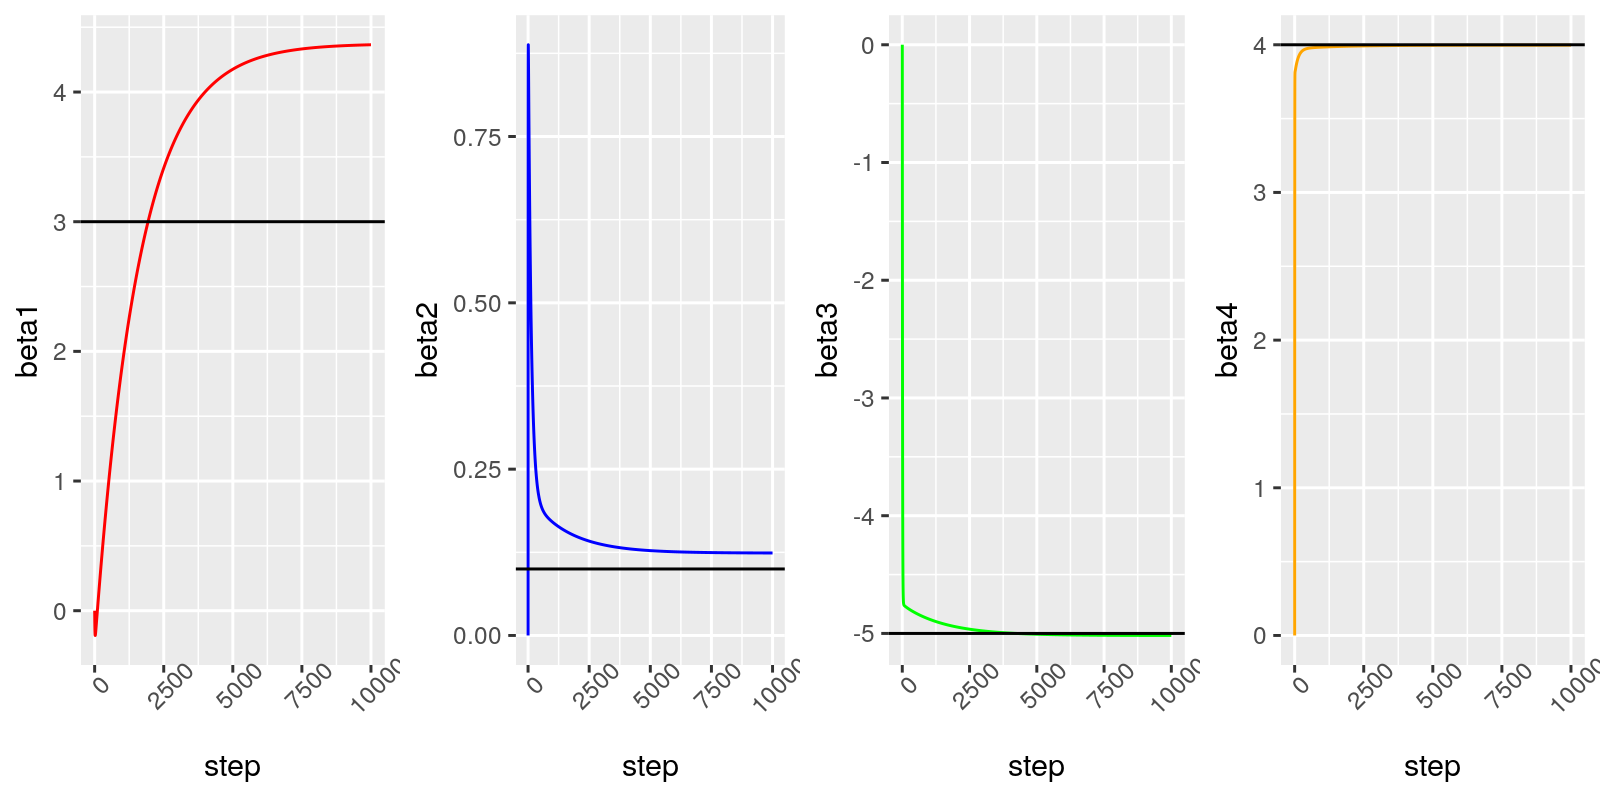

In [12]:
options(repr.plot.height=4,repr.plot.width=8)
g1<-ggplot(x_historico,aes(x=step))+geom_line(aes(y=beta1),color='red')+
    theme(axis.text.x = element_text(angle = 45))+geom_hline(yintercept=beta_real[1],color='black')
g2<-ggplot(x_historico,aes(x=step))+geom_line(aes(y=beta2),color='blue')+
    theme(axis.text.x = element_text(angle = 45))+geom_hline(yintercept=beta_real[2],color='black')
g3<-ggplot(x_historico,aes(x=step))+geom_line(aes(y=beta3),color='green')+
    theme(axis.text.x = element_text(angle = 45))+geom_hline(yintercept=beta_real[3],color='black')
g4<-ggplot(x_historico,aes(x=step))+geom_line(aes(y=beta4),color='orange')+
    theme(axis.text.x = element_text(angle = 45))+geom_hline(yintercept=beta_real[4],color='black')

library(egg)
grid.arrange(g1, g2, g3,g4, nrow = 1)

In [13]:
model$coefficients

(Intercept)          x1          x2          x3 
   4.372915    0.123849   -5.017782    3.997379

#### Regularización Lasso

Ahora vamos a aplicar una regularización L1 o de Lasso, añadamos el término:

\\[
Coste = {1 \over n} \sum_{i=0}^n{(Y-\hat{Y})^2}+\lambda \sum_j | \beta_j |
\\]

De los coeficientes $\beta_j$ no tenemos en cuenta la intersección. Notar que:
* Cuando $\lambda \rightarrow 0$, entonces $\beta_{LASSO} \rightarrow \beta_{original mínimos cuadrados}$ 
* Cuando $\lambda \rightarrow \infty$, entonces $\beta_{LASSO} \rightarrow 0$ 

Tratamos de minimizar la suma de todos los demás coeficientes:

In [14]:
#lambda<-40
lambda<-2
loss_lasso<-function(beta){
    sum((df$y-myfunction(df[,-ncol(df)],beta))^2)/(2*nrow(df))+lambda*sum(abs(beta[-1]))
}
x_historico<-optim_beta(myfunction,loss_lasso,maxiter=1e4)

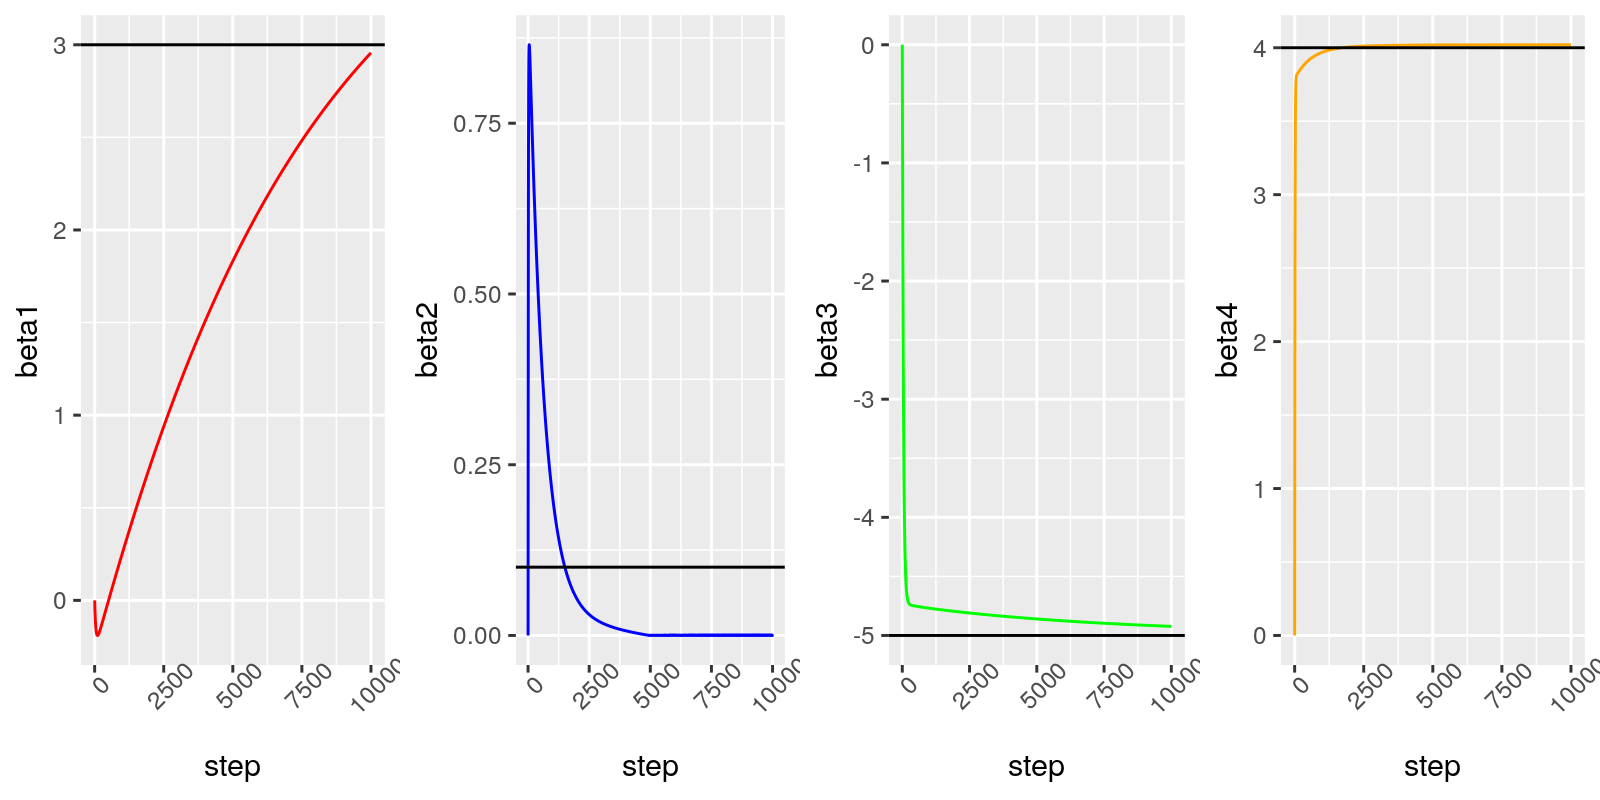

In [15]:
options(repr.plot.height=4,repr.plot.width=8)
library(ggplot2)

g1<-ggplot(x_historico,aes(x=step))+geom_line(aes(y=beta1),color='red')+
    theme(axis.text.x = element_text(angle = 45))+geom_hline(yintercept=beta_real[1],color='black')
g2<-ggplot(x_historico,aes(x=step))+geom_line(aes(y=beta2),color='blue')+
    theme(axis.text.x = element_text(angle = 45))+geom_hline(yintercept=beta_real[2],color='black')
g3<-ggplot(x_historico,aes(x=step))+geom_line(aes(y=beta3),color='green')+
    theme(axis.text.x = element_text(angle = 45))+geom_hline(yintercept=beta_real[3],color='black')
g4<-ggplot(x_historico,aes(x=step))+geom_line(aes(y=beta4),color='orange')+
    theme(axis.text.x = element_text(angle = 45))+geom_hline(yintercept=beta_real[4],color='black')

library(egg)
grid.arrange(g1, g2, g3,g4, nrow = 1)

La regularización **Lasso** descarta los componentes que tienen menos certeza en el resultado final, es decir, los coeficientes con un pvalor más alto.

En R existe el paquete [glmnet](https://web.stanford.edu/~hastie/glmnet/glmnet_alpha.html) que te permite apilcar regularización a modelos lineales

In [16]:
library(glmnet)
model<-glmnet(as.matrix(df[,c('x1','x2','x3')]),
              as.matrix(df[,'y']),
              lambda=2,alpha=1, standardize=F)
coefficients(model)

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:pracma’:

    expm, lu, tril, triu


Loaded glmnet 4.1-4



4 x 1 sparse Matrix of class "dgCMatrix"
                   s0
(Intercept)  4.224618
x1           .       
x2          -4.993921
x3           4.021538

In [18]:
model


Call:  glmnet(x = as.matrix(df[, c("x1", "x2", "x3")]), y = as.matrix(df[,      "y"]), alpha = 1, lambda = 2, standardize = F) 

  Df  %Dev Lambda
1  2 98.89      2

Una vez que nos decantamos por una regularización Lasso ¿Cómo obtenemos el valor óptimo de $\lambda$ ?

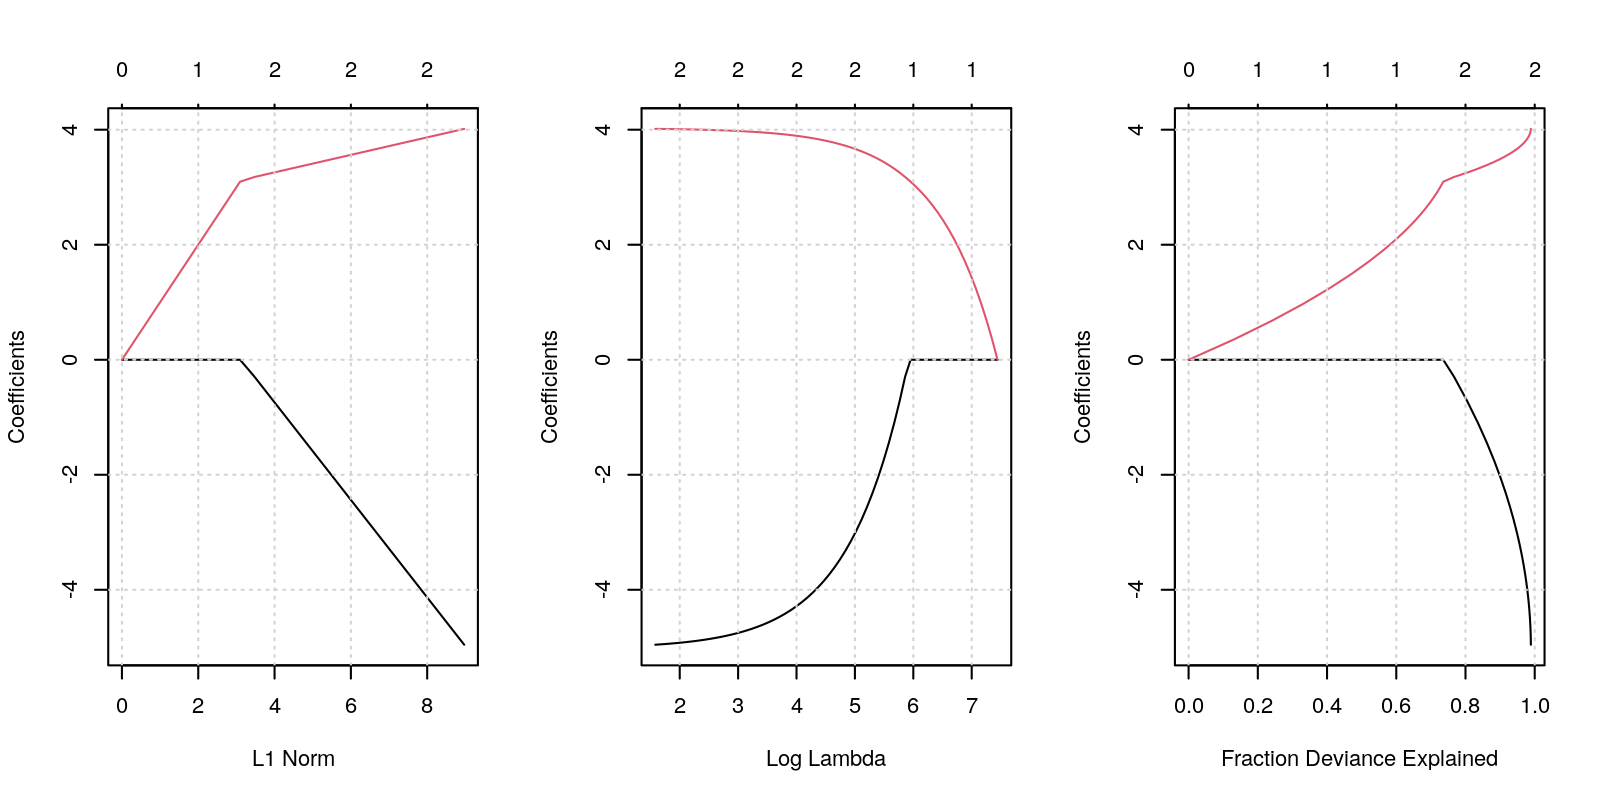

In [19]:
fit<-glmnet(as.matrix(df[,c('x1','x2','x3')]),as.matrix(df[,'y']),alpha=1, standardize=F)
par(mfrow=c(1,3))
plot(fit,label=TRUE)
grid()
plot(fit,label=TRUE,xvar="lambda")
grid()
plot(fit,label=TRUE,xvar="dev")
grid()
#print(fit)

In [21]:
#Calculamos los coeficientes para un valor dado de lambda
l<-exp(6)
coef(fit,s=l)
#Mostramos el valor de R^2 que se corresponde con la Fracción de la desviación típica explicada
caret::postResample(predict(fit,newx=as.matrix(df[,c('x1','x2','x3')]),s=l),df$y)

4 x 1 sparse Matrix of class "dgCMatrix"
                    s1
(Intercept) -28.748311
x1            .       
x2            .       
x3            3.052882

RMSE   Rsquared        MAE 
48.5778924  0.7752015 40.1895646

Podemos ir probando con varios valores de $\lambda$ hasta encontrar con el *óptimo*.

,x1,x2,x3,y,pred1,pred2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,6.898671,6.337996,12.39149119,32.3059753,22.310340,9.094342
2,-4.797351,-3.517863,-4.85781066,0.4048667,1.900406,-43.583065
3,-9.537110,1.287266,-48.19645484,-197.5091619,-195.898978,-175.934358
4,7.247991,6.740426,32.63134319,85.3873655,101.571459,70.904549
5,-3.308241,13.036264,0.06065023,-54.3656883,-60.385715,-28.562645
6,2.635777,-7.854919,7.40575730,70.0538596,72.625699,-6.131523


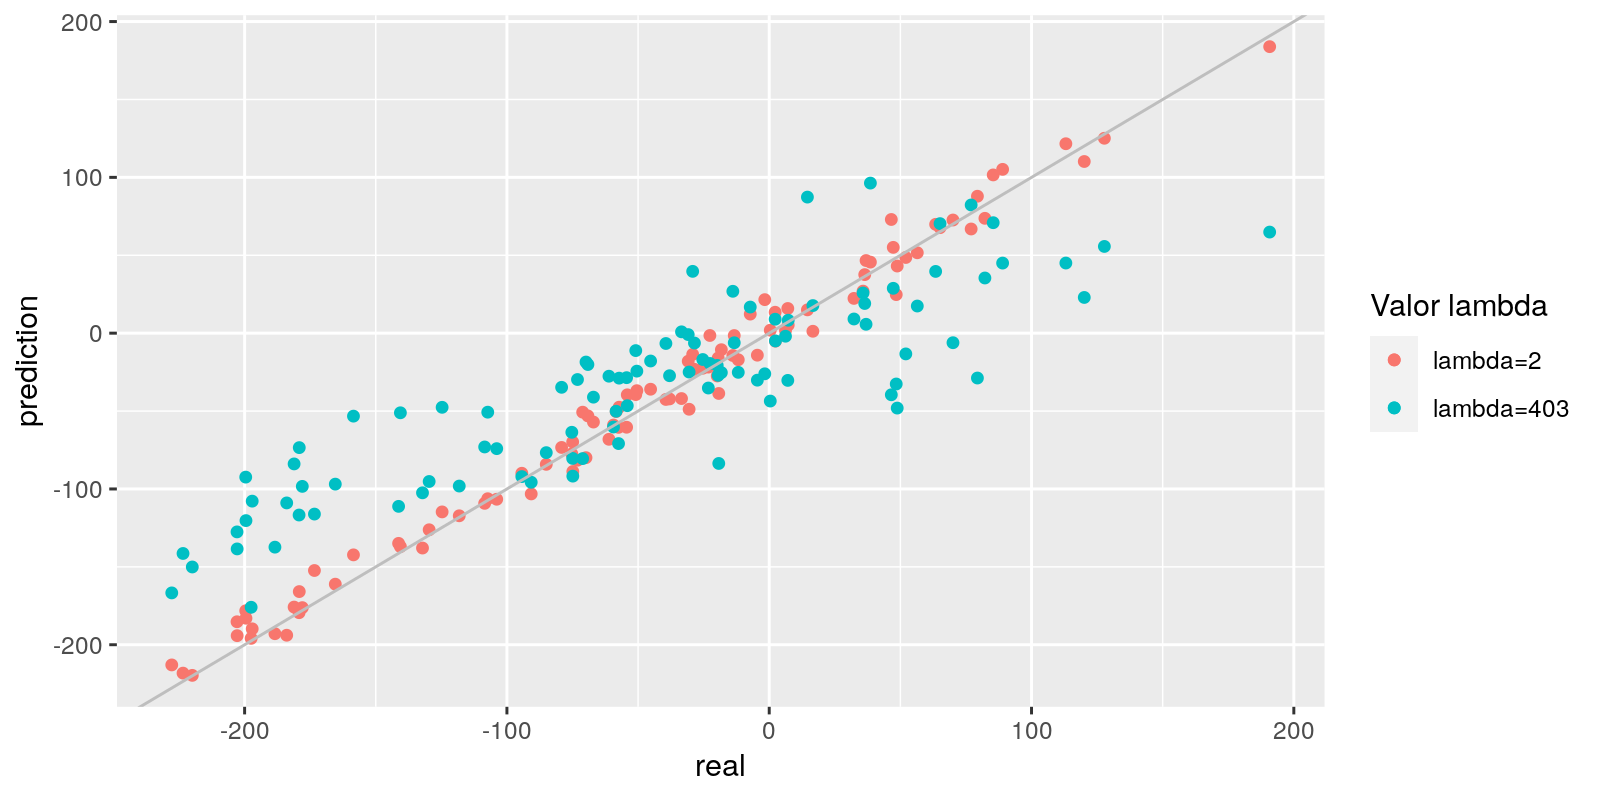

In [22]:
lambda1 <- 2
lambda2 <- round(exp(6))
df_test<-get_example_data_frame(n=100)
df_test[,c("pred1","pred2")]<-predict(fit,newx=as.matrix(df_test[,c('x1','x2','x3')]),s=c(lambda1,lambda2))
head(df_test)
ggplot(df_test,aes(x=y))+
    geom_point(aes(y=pred1,color=paste0("lambda=",lambda1)))+
    geom_point(aes(y=pred2,color=paste0("lambda=",lambda2)))+
    geom_abline(slope=1,intercept=0,color="gray")+
    scale_colour_discrete(name = "Valor lambda" )+
    ylab("prediction")+xlab("real")

Busca el mejor elemento utilizando validación cruzada (*cross-validation*):

![](img/cross-validation.png)

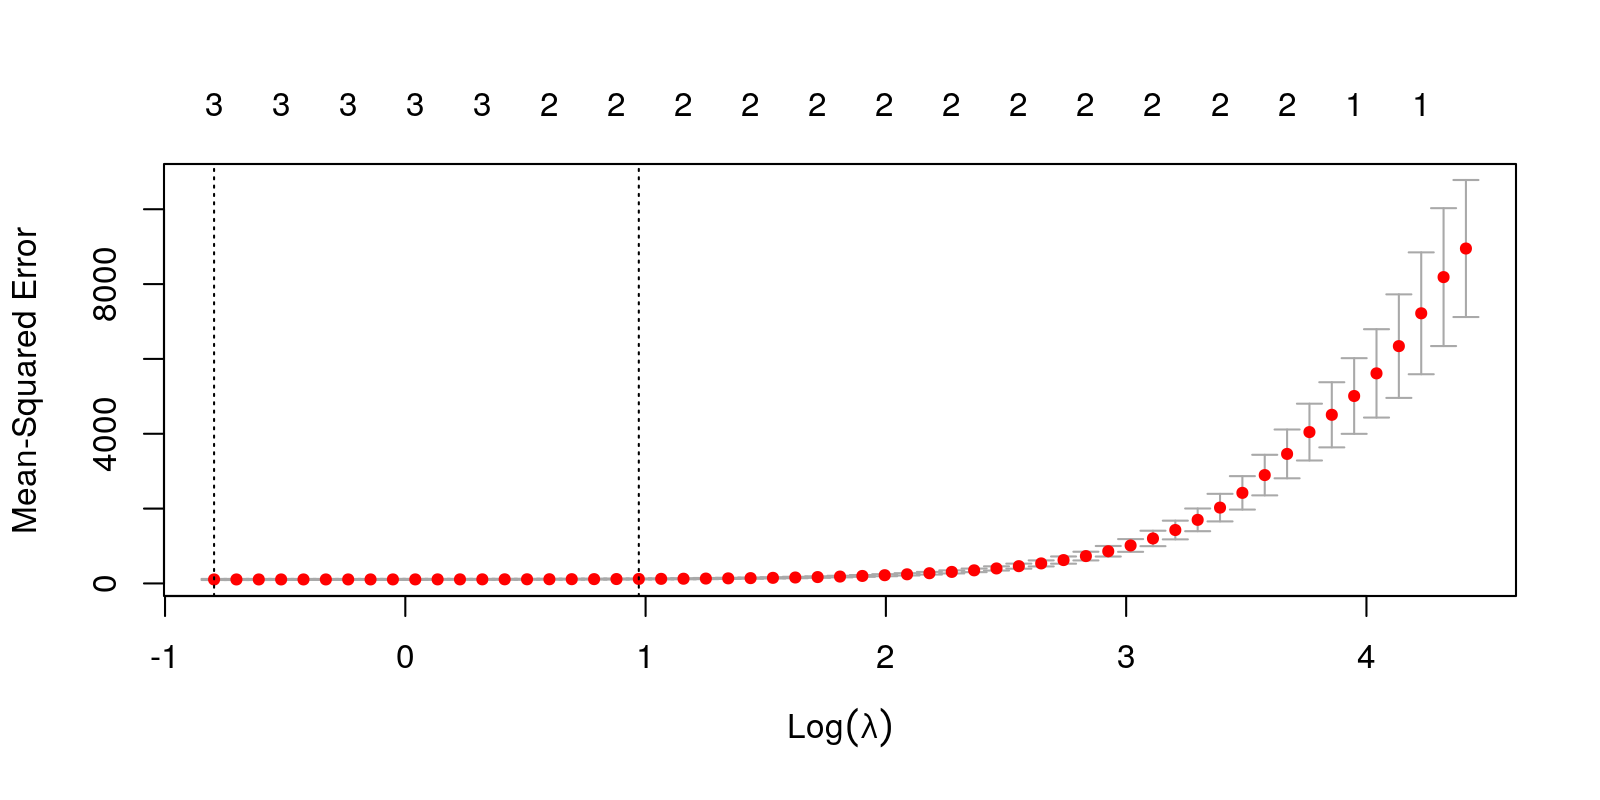

In [23]:
cvfit<-cv.glmnet(as.matrix(df[,c('x1','x2','x3')]),as.matrix(df[,'y']),nfolds=10,alpha=1, standarize=F)
plot(cvfit)

El modelo que tiene un error cuadrático medio más bajo aparece en la variable *cvfit$lambda.min*

El modelo que tiene un mayor valor de $\lambda$ cuya varianza del error está dentro de 1 *desviación típica* del *mínimo* aparece en la variable *cvfit$lambda.1se*. 

Al hacer cross-validation el MSE no será un valor único sino que tendremos *nfolds* diferentes. De todos estos MSE podemos calular la *media* y la *desviación típica*. El valor de *lambda.1se* viene a significar como el modelo más sencillo ($\lambda$ más alto) que no se diferencia considerablemente del *mínimo*.

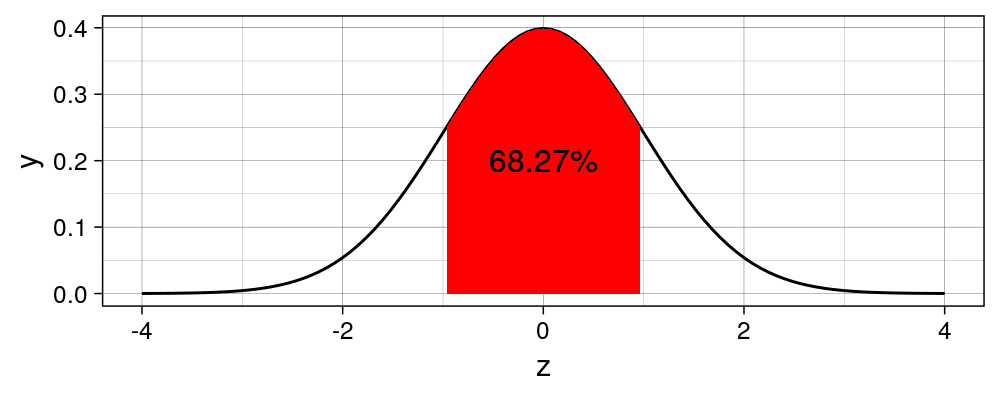

In [24]:
options(repr.plot.height=2,repr.plot.width=5)
lamda_se<-1
qsd009<-function(x){    
    out<-dnorm(x)
    out[x> lamda_se  | x< -lamda_se  ]<-NA
    out
}
xdf<-data.frame(z=c(-4,4))
ggplot(xdf,aes(x=z))+stat_function(fun=dnorm)+
  stat_function(fun=qsd009, geom="area",fill="red")+
  geom_text(x=0,y=0.2,size=4,label=paste0(100*round(pnorm(lamda_se)-pnorm(-lamda_se),4),"%"))+  
  theme_linedraw()
options(repr.plot.height=7,repr.plot.width=7)

In [25]:
cvfit$lambda.min
cvfit$lambda.1se

[1] 0.4511842

[1] 2.642595

In [31]:
coef(cvfit, s = "lambda.1se")

4 x 1 sparse Matrix of class "dgCMatrix"
                   s1
(Intercept)  2.324143
x1           .       
x2          -4.710797
x3           3.896718

Su R^2 estimado será:

In [32]:
cvfit$glmnet.fit$dev.ratio[which(cvfit$glmnet.fit$lambda == cvfit$lambda.1se)] 

[1] 0.98732

En resumen, para hacer una predicción Lasso con glmnet haríamos:

In [33]:
cvfit<-cv.glmnet(as.matrix(df[,c('x1','x2','x3')]),as.matrix(df[,'y']),nfolds=10,alpha=1, standarize=F)

In [34]:
df_test<-get_example_data_frame(n=100)



df_test[,c("pred")]<-predict(cvfit,newx=as.matrix(df_test[,c('x1','x2','x3')]),s=cvfit$lambda.1se)
head(df_test)
caret::postResample(df_test$y,df_test$pred)

,x1,x2,x3,y,pred
,<dbl>,<dbl>,<dbl>,<dbl>,"<dbl[,1]>"
1,1.9361383,3.972058,5.3340171,11.30191,4.534398
2,4.8417332,16.173018,8.0295401,-38.64590,-42.743196
3,9.0567426,-9.289640,9.5627518,79.14404,83.899767
4,-0.2075752,15.810312,-0.2039507,-62.10379,-73.203000
5,-8.3342531,3.095098,-45.7535663,-188.56495,-190.972616
6,-4.8014400,22.613531,-20.9445618,-192.01536,-186.498193


RMSE   Rsquared        MAE 
11.0277353  0.9881218  9.1433518

#### Regularización Ridge

Ahora vamos a aplicar una regularización L2 o Ridge, añadamos el término:

\\[
Coste = {1 \over n} \sum_{i=0}^n{(Y-\hat{Y})^2}+\lambda \sum_j \beta_j^2
\\]

De los coeficientes $\beta_j$ no tenemos en cuenta la intersección. Notar que:
* Cuando $\lambda \rightarrow 0$, entonces $\beta_{RIDGE} \rightarrow \beta_{original mínimos cuadrados}$ 
* Cuando $\lambda \rightarrow \infty$, entonces $\beta_{RIDGE} \rightarrow 0$ 

Tratamos de minimizar la suma de todos los demás coeficientes:

In [ ]:
lambda<-10
#lambda<-1000
loss_ridge<-function(beta){
    mean((df$y-myfunction(df[,c('x1','x2','x3')],beta))^2)+lambda*sum(beta[c(2,3,4)]^2)
}

x_historico<-optim_beta(myfunction,loss_ridge,maxiter=1e4,delta=0.0005 )

In [ ]:
options(repr.plot.height=4,repr.plot.width=8)
library(ggplot2)

g1<-ggplot(x_historico,aes(x=step))+geom_line(aes(y=beta1),color='red')+
    theme(axis.text.x = element_text(angle = 45))+geom_hline(yintercept=beta_real[1],color='black')
g2<-ggplot(x_historico,aes(x=step))+geom_line(aes(y=beta2),color='blue')+
    theme(axis.text.x = element_text(angle = 45))+geom_hline(yintercept=beta_real[2],color='black')
g3<-ggplot(x_historico,aes(x=step))+geom_line(aes(y=beta3),color='green')+
    theme(axis.text.x = element_text(angle = 45))+geom_hline(yintercept=beta_real[3],color='black')
g4<-ggplot(x_historico,aes(x=step))+geom_line(aes(y=beta4),color='orange')+
    theme(axis.text.x = element_text(angle = 45))+geom_hline(yintercept=beta_real[4],color='black')

library(egg)
grid.arrange(g1, g2, g3,g4, nrow = 1)

La regularización **Ridge** acerca los coeficientes de las variables más correladas el uno hacia al otro.

También podemos usar el paquete [glmnet](https://web.stanford.edu/~hastie/glmnet/glmnet_alpha.html), en este caso con $\alpha=0$ ya que utiliza la siguiente función de coste:
\\[
Coste = {1 \over n} \sum_{i=0}^n{(Y-\hat{Y})^2}+ \alpha \lambda \sum_j | \beta_j |+(1-\alpha)/2 \lambda \sum_j \beta_j^2
\\]

In [ ]:
library(glmnet)
model<-glmnet(as.matrix(df[,c('x1','x2','x3')]),as.matrix(df[,'y']),lambda=20,alpha=0, standardize=F)
coefficients(model)

In [ ]:
fit<-glmnet(as.matrix(df[,c('x1','x2','x3')]),as.matrix(df[,'y']),alpha=0, standardize=F)

par(mfrow=c(1,3))
plot(fit,label=TRUE)
plot(fit,label=TRUE,xvar="lambda")
plot(fit,label=TRUE,xvar="dev")
grid()
#print(fit)

In [ ]:
cvfit<-cv.glmnet(as.matrix(df[,c('x1','x2','x3')]),as.matrix(df[,'y']),nfolds=10,alpha=0, standardize=F)
plot(cvfit)

El modelo que tiene un error cuadrático medio más bajo aparece en la variable *cvfit$lambda.min*

El modelo que tiene un mayor valor de $\lambda$ cuya varianza del error está dentro de 1 *desviación típica* del *mínimo* aparece en la variable *cvfit$lambda.1se*. 

Al hacer cross-validation el MSE no será un valor único sino que tendremos *nfolds* diferentes. De todos estos MSE podemos calular la *media* y la *desviación típica*. El valor de *lambda.1se* viene a significar como el modelo más sencillo ($\lambda$ más alto) que no se diferencia considerablemente del *mínimo*.

In [ ]:
cvfit$lambda.min
cvfit$lambda.1se

In [ ]:
coef(cvfit, s = "lambda.1se")

In [ ]:
cvfit$glmnet.fit$dev.ratio[which(cvfit$glmnet.fit$lambda == cvfit$lambda.1se)] 

En resumen, para hacer una predicción Ridge con glmnet haríamos:

In [ ]:

cvfit<-cv.glmnet(as.matrix(df[,c('x1','x2','x3')]),as.matrix(df[,'y']),nfolds=10,alpha=0, standardize=F)

df_test<-get_example_data_frame(n=100)
df_test[,c("pred")]<-predict(cvfit,newx=as.matrix(df_test[,c('x1','x2','x3')]),s=cvfit$lambda.1se)
head(df_test)
caret::postResample(df_test$y,df_test$pred)

### Prediciendo la dureza del hormigón con regularización

Resumen: El hormigón es el material más importante en la ingeniería civil. La resistencia a la compresión del hormigón es una función altamente no lineal de la edad y ingredientes Estos ingredientes incluyen cemento, escoria de alto horno, cenizas volantes, agua, superplastificante, agregado grueso y agregado fino.

Fuente:
https://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength

In [ ]:
concrete<-read.csv("data/Concrete_Data.csv",
                   col.names=c("cemento","escoria","cenizas","agua","plastificante","aggrueso","agfino","edad","resistencia"))
head(concrete)

In [ ]:
options(repr.plot.height=5,repr.plot.width=8,repr.plot.res = 200)

GGally::ggpairs(concrete, 
       #lower = list(continuous = GGally::wrap("density", alpha = 0.8,size=0.2,color='blue'))
       lower = list(continuous = GGally::wrap("points", alpha = 0.3,size=0.1,color='blue'))
       )

In [ ]:
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(glmnetUtils))

In [ ]:
set.seed(12)

idx<-sample(1:nrow(concrete),nrow(concrete)*0.7)

concrete.train=concrete[idx,]
concrete.test=concrete[-idx,]

**Regresión lineal**

In [ ]:
lm_model<-lm(resistencia~
           cemento*escoria*agua*plastificante*aggrueso*agfino*edad*cenizas,data = concrete.train)
    
lm_yp_train<-predict(lm_model,concrete.train)
caret::postResample(pred=lm_yp_train, obs=concrete.train$resistencia)


lm_yp_test<-predict(lm_model,concrete.test)
caret::postResample(pred=lm_yp_test, obs=concrete.test$resistencia)

**Regularización**

En este caso tenemos variables que provienen de diferentes unidades y tienen rangos muy diferentes de valores, por lo tanto para hacer los coeficientes comparables entre si, deberíamos estandarizarlos.

El resultado consiste en dejar nuestros datos con media 0 y varianza 1:
\\[
X_n=\frac{X-\mu}{\sigma}
\\]

esto lo realiza por si solo el paquete glmnet o glmnetutils

In [ ]:
cv<-glmnetUtils::cv.glmnet(formula=resistencia~cemento*escoria*cenizas*agua*plastificante*aggrueso*agfino*edad,
                            data=concrete.train,alpha=1,
                            nfold= 10,
                            type.measure="mse",
                            standardize = T)
ggplot(data.frame(lambda=cv$lambda,cross_validated_mean_error=cv$cvm),
       aes(x=lambda,y=cross_validated_mean_error))+geom_line()
paste0("El valor lambda con el menor error es:",cv$lambda.min)
paste0("El valor lambda más alto que se encuentra a una distancia 1sd es:",cv$lambda.1se)
paste0("El R^2 estimado es", cv$glmnet.fit$dev.ratio[which(cv$glmnet.fit$lambda == cv$lambda.1se)]) 
ggplot(data.frame(lambda=cv$lambda,r2=cv$glmnet.fit$dev.ratio),
       aes(x=lambda,y=r2))+geom_line()+xlim(0,1)

In [ ]:
reg_yp_train <- predict(cv,
                     concrete.train, 
                     s=cv$lambda.min)
caret::postResample(reg_yp_train,concrete.train$resistencia)

In [ ]:
reg_yp_test <- predict(cv,
                     concrete.test, 
                     s=cv$lambda.min)
caret::postResample(reg_yp_test,concrete.test$resistencia)

\\[
MSE = {1 \over n} \sum_{i=0}^n{(y_i-y_i')^2}
\\]
\\[
R^2=1-\frac{\sum_i (y_i-y_i')^2}{\sum_i (y_i-\bar{y})^2}
\\]

In [ ]:
residual_test <- concrete.test$resistencia-reg_yp_test
plot(concrete.test$resistencia,residual_test)
qqnorm(residual_test)
qqline(residual_test,col="orange")

In [ ]:
data.frame(real=concrete.test$resistencia,
                       lm=lm_yp_test,
                       reg=reg_yp_test[,1]) %>% 
   mutate(res_lm=real-lm) %>% 
   mutate(res_reg=real-reg) -> total_pred
head(total_pred)

In [ ]:
library(reshape2)

total_pred %>% select(res_lm,res_reg) %>% melt() %>% 
  ggplot(aes(x=value,color=variable))+geom_density()


total_pred %>% ggplot(aes(x=real))+
  geom_point(aes(y=reg,color="Reg"),alpha=0.5)+
  geom_point(aes(y=lm,color="Lm"),alpha=0.5)+geom_abline(intercept = 0,slope=1)

**Si utilizamos lambda.1se como valor de lambda** el R² y el MSE empeoran ligeramente, pero siguen siendo mejores que la regresión lineal.

In [ ]:
reg_yp_train <- predict(cv,
                     concrete.train, 
                     s=cv$lambda.1se)
caret::postResample(reg_yp_train,concrete.train$resistencia)

reg_yp_test <- predict(cv,
                     concrete.test, 
                     s=cv$lambda.1se)
caret::postResample(reg_yp_test,concrete.test$resistencia)

data.frame(real=concrete.test$resistencia,
                       lm=lm_yp_test,
                       reg=reg_yp_test[,1]) %>% 
   mutate(res_lm=real-lm) %>% 
   mutate(res_reg=real-reg) -> total_pred

total_pred %>% select(res_lm,res_reg) %>% melt() %>% 
  ggplot(aes(x=value,color=variable))+geom_density()


In [ ]:
#¿Tiene sesgo nuestro modelo?
colMeans(total_pred[,c("res_lm","res_reg")])